# Calculate Nino 3.4 index to check if eruptions line up with El Nino events
This script opens up all the CMIP6 historical model run files with data on precipitation pr and surface temperature tas and loops over the files. It calculates the Nino3.4 index for the data to test which years have an El Nino event and if they occur after volcanic eruptions. 


In [1]:
import xarray as xr, matplotlib.pyplot as plt
#import sys 
#sys.path.append('') # use this if the function file is in a different directory to the notebook
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load

In [2]:
# import custom functions
import anomaly_function as func # imports the function
import model_figures as func2

In [3]:
# use this to reload the function file if I make any edits to it
func = reload(func) 
func2 = reload(func2)

In [4]:
!ls /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/ts/gr1.5

v20200302


In [5]:
!ls /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon

huss  pr  psl  tas  ts	uas  vas  wap


In [6]:
# store each section of the directory as a string
institution_dir = '/g/data/lp01/CMIP6/CMIP/'
tas_dir = '/historical/r1i1p1f1/Amon/tas/gr1.5/'
pr_dir = '/historical/r1i1p1f1/Amon/pr/gr1.5/'
ts_dir = '/historical/r1i1p1f1/Amon/ts/gr1.5/'
print(institution_dir, tas_dir, pr_dir, ts_dir)

/g/data/lp01/CMIP6/CMIP/ /historical/r1i1p1f1/Amon/tas/gr1.5/ /historical/r1i1p1f1/Amon/pr/gr1.5/ /historical/r1i1p1f1/Amon/ts/gr1.5/


## Read in model data

In [7]:
models_tas = func.read_models(institution_dir, tas_dir, '1850-01','2015-01')

49 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
Model MPI-ESM1-2-HR has different time so is now removed
Model E3SM-1-0 has different time so is now removed
Model EC-Earth3-Veg has different time so is now removed
45 models have been successfully loaded into an xarray


In [8]:
models_pr = func.read_models(institution_dir, pr_dir, '1850-01','2015-01')

48 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
47 models have been successfully loaded into an xarray


In [9]:
models_ts = func.read_models(institution_dir, ts_dir, '1850-01','2015-01')

49 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
Model E3SM-1-0 has different time so is now removed
47 models have been successfully loaded into an xarray


In [10]:
# make sure the models are the same for both vairables
# delete the height from the models_tas array (if it hasn't been deleted already)
if 'height' in models_tas:
    del models_tas['height']
# delete models that aren't common between variables
models_tas = models_tas.where(models_tas.model.isin(models_pr.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_tas.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_ts.model), drop = True)
models_ts = models_ts.where(models_ts.model.isin(models_tas.model), drop = True)

#chekc that the models are the same for both variables and if so print True
models_tas.model.equals(models_ts.model)

True

In [11]:
# get rid of models with issues
models = models_ts.drop_sel(model=['CIESM'])

In [12]:
# sort models alphabetically and prints final model list
models = models.sortby('model')
print('The following', len(models.model.data), 'models will be used in all subsequent calculations: \n')
print(models.model.data)

The following 43 models will be used in all subsequent calculations: 

['ACCESS-CM2' 'ACCESS-ESM1-5' 'AWI-CM-1-1-MR' 'AWI-ESM-1-1-LR'
 'BCC-CSM2-MR' 'BCC-ESM1' 'CAMS-CSM1-0' 'CAS-ESM2-0' 'CESM2' 'CESM2-FV2'
 'CESM2-WACCM' 'CESM2-WACCM-FV2' 'CMCC-CM2-HR4' 'CMCC-CM2-SR5' 'CanESM5'
 'E3SM-1-1' 'E3SM-1-1-ECA' 'EC-Earth3' 'EC-Earth3-AerChem'
 'EC-Earth3-Veg-LR' 'FGOALS-f3-L' 'FGOALS-g3' 'FIO-ESM-2-0' 'GFDL-CM4'
 'GFDL-ESM4' 'GISS-E2-1-G' 'GISS-E2-1-G-CC' 'GISS-E2-1-H' 'IITM-ESM'
 'INM-CM4-8' 'INM-CM5-0' 'IPSL-CM6A-LR' 'KACE-1-0-G' 'MIROC6'
 'MPI-ESM-1-2-HAM' 'MPI-ESM1-2-LR' 'MRI-ESM2-0' 'NESM3' 'NorCPM1'
 'NorESM2-LM' 'NorESM2-MM' 'SAM0-UNICON' 'TaiESM1']


## Select out regions
Right now I have all the models stored in one array so from hereafter I can calculate anomalies etc.  

In [13]:
# area weighting 
models_w = models*np.cos(models_ts.lat*(np.pi/180))

## Nino 3.4

In [14]:
# add the multi-model mean to the data-array
models_w_mmm = func.add_mmm(models_w)

In [15]:
# calculate the nino3.4 index for all models (and mmm) for every month
nino34_index = func.nino34(models_w_mmm, '1850-01', '1880-01')

# Figures

In [16]:
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])

In [17]:

nino34_mmm = nino34_index.sel(model='ACCESS-CM2').ts.sel(time=slice('1873-08','1893-08'))

In [20]:
# set the threshold for el nino/la nia events
threshold = 0.8

<AxesSubplot:ylabel='Sea surface temperature anomaly [$\\degree$C]'>

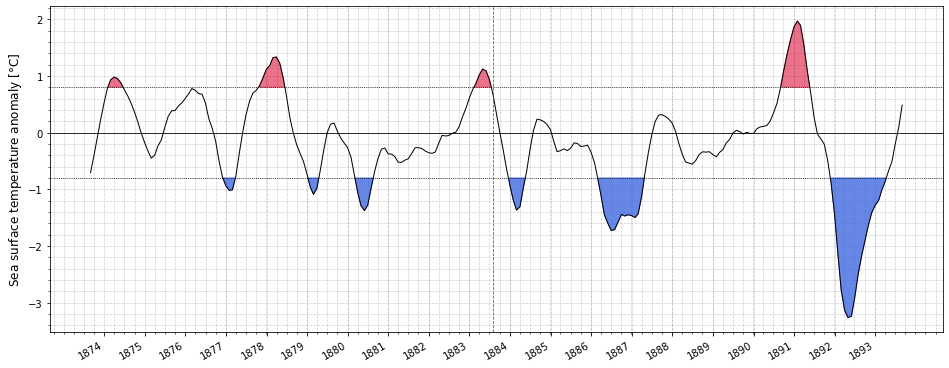

In [21]:
# plot time series of nino3.4 index for the multimodel mean dataset 
fig, axes = plt.subplots(figsize=(16,6))

func2.nino34_plot(nino34_mmm, e_date, threshold, ax = axes)

#plt.savefig('nino34_plot_mmm.png', dpi=300, bbox_inches='tight')

## next i want to classify each year as either el nino, la nino or neutral and then plot the results in a table 
to do this i need to count the number of el nino/la nina/ neutral events each year 
record count of dominant event for the year
then write the count and colour code (red el nino, blue la nina, white/grey neutral)  

# i want to do the below cell but have a count for each year 
# then i want to record the percentage of the highest event and colour code the cell that colour 

In [25]:
nino34_index = nino34_index.sel(time=slice('1882-08','1888-08'))
nino34_index

<xarray.Dataset>
Dimensions:  (model: 44, time: 73)
Coordinates:
  * time     (time) datetime64[ns] 1882-08-31 1882-09-30 ... 1888-08-31
  * model    (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'Multi-model mean'
    month    (time) int64 dask.array<chunksize=(4,), meta=np.ndarray>
Data variables:
    ts       (model, time) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>

In [110]:
# check which months are above the threshold for el nio and la nina and assign 1 for nino, -1 for nina
nino_month = xr.where(nino34_index>=threshold, 1, 0)
nina_month = xr.where(nino34_index<=-threshold, -1, 0)

nino34month = nino_month + nina_month
nino34month

<xarray.Dataset>
Dimensions:  (model: 44, time: 73)
Coordinates:
  * time     (time) datetime64[ns] 1882-08-31 1882-09-30 ... 1888-08-31
  * model    (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'Multi-model mean'
    month    (time) int64 dask.array<chunksize=(4,), meta=np.ndarray>
Data variables:
    ts       (model, time) int64 dask.array<chunksize=(1, 1), meta=np.ndarray>

In [102]:
nino34_month_df = nino34month.to_dataframe()
nino34_month_df

month  ts
model            time                 
ACCESS-CM2       1882-08-31      8   0
                 1882-09-30      9   0
                 1882-10-31     10   0
                 1882-11-30     11   0
                 1882-12-31     12   0
...                            ...  ..
Multi-model mean 1888-04-30      4   0
                 1888-05-31      5   0
                 1888-06-30      6   0
                 1888-07-31      7   0
                 1888-08-31      8   0

[3212 rows x 2 columns]

In [134]:
# The text for the combined result
result_month = nino34_month_df.pivot_table(index='model', columns=['time'], values='ts')
type_background = {
    1 : 'color: crimson; background-color: crimson',
    -1 : 'color: royalblue;background-color: royalblue',
    0 : 'color: grey;background-color: grey',
}
background = result_month.applymap(lambda x: type_background[x])
table = result_month.style.apply(lambda x: background, axis=None)
table

# Produce a table showing onset date of el nino events (anomalies above threshold that last longer than 5 months) 

In [26]:
# counts the number of el nino months in the time period and records it as a percentage 
nino_count = 100*(nino34_index.where(nino34_index>=threshold).count('time') / nino34_index.count('time'))
# counts the number of la nina months in the time period and records it as a percentage 
nina_count = 100*(nino34_index.where(nino34_index<=-threshold).count('time') / nino34_index.count('time'))
# counts the number of neutral months in the time period and records it as a percentage 
neutral_count = 100*(nino34_index.count('time')-nino_count-nina_count) / nino34_index.count('time')

In [27]:
import climtas

nino_events = climtas.event.find_events(nino34_index.ts>=threshold, min_duration=5)
#nina_events = climtas.event.find_events(nino34_index.ts<=-0.4, min_duration=5)

In [28]:
nina_events = climtas.event.find_events(nino34_index.ts<=-threshold, min_duration=5)

In [29]:
coords_nino = climtas.event.event_coords(nino34_index, nino_events)

,model,time,event_duration
0,BCC-CSM2-MR,1882-09-30,212 days
1,E3SM-1-1,1882-08-31,273 days
2,KACE-1-0-G,1882-11-30,182 days
3,SAM0-UNICON,1882-11-30,182 days
4,MIROC6,1882-09-30,273 days
5,ACCESS-CM2,1883-02-28,153 days
6,CESM2-WACCM,1882-08-31,365 days
7,GISS-E2-1-G-CC,1882-08-31,365 days
8,AWI-CM-1-1-MR,1883-03-31,214 days
9,CAMS-CSM1-0,1883-01-31,273 days


In [95]:
# Fix event_duration with NaT
# Rows where event_duration is NaT
nat_rows = coords_nino['event_duration'].isna()

# One timestep
# Since my data is in steps of a month this won't be exact - months have different lengths
tstep = nino34_index.time.values[1] - nino34_index.time.values[0]

# Fill NaT rows' event_duration
coords_nino.loc[nat_rows, 'event_duration'] = nino34_index.time.values[-1] + tstep - coords.loc[nat_rows, 'time']
# Now bin by time - first set the 'time' column as the index, but leave a copy in the table (drop=False)
#c = coords_nino.set_index('time', drop=False)

In [96]:
# Now let's add nina events - I'm generating them the same way
coords_nina = climtas.event.event_coords(nino34_index, nina_events)

nat_rows = coords_nina['event_duration'].isna()
tstep = nino34_index.time.values[1] - nino34_index.time.values[0]
coords_nina.loc[nat_rows, 'event_duration'] = nino34_index.time.values[-1] + tstep - coords_nina.loc[nat_rows, 'time']

In [97]:
# Mark the type of each event
coords_nino['type'] = 'nino'
coords_nina['type'] = 'nina'

# Join the events together
coords_all = pd.concat([coords_nino, coords_nina])

coords_all

,model,time,event_duration,type
0,BCC-CSM2-MR,1882-09-30,212 days,nino
1,E3SM-1-1,1882-08-31,273 days,nino
2,KACE-1-0-G,1882-11-30,182 days,nino
3,SAM0-UNICON,1882-11-30,182 days,nino
4,MIROC6,1882-09-30,273 days,nino
...,...,...,...,...
37,CMCC-CM2-SR5,1887-06-30,397 days,nina
38,CESM2-WACCM,1887-11-30,275 days,nina
39,EC-Earth3-AerChem,1887-09-30,336 days,nina
40,CAMS-CSM1-0,1887-09-30,366 days,nina


In [98]:
coords_all = coords_all.set_index('time', drop=False)

# Now group the index column into years, returning the first event in each month??
grouped_all = coords_all.groupby('model').resample('M').first()

# Drop empty years
grouped_all = grouped_all.dropna()

# strftime lets us format dates in different ways so we have month and year 
start_all = grouped_all['time'].dt.strftime("%Y %b")
# format duration so we have e.g. '6 mon'
duration_all = grouped_all['event_duration'].apply(lambda x: f'{round(x.days/30)}mon')
# pivot table with nice values
grouped_all['value'] = duration_all#start_all + ', ' + duration_all
#grouped_all['time'] = start_all # tryingto changethe format of the time display

grouped_all[['time','model','value','type']]

time          model  value  type
model         time                                             
ACCESS-CM2    1883-02-28 1883-02-28     ACCESS-CM2   5mon  nino
              1883-12-31 1883-12-31     ACCESS-CM2   5mon  nina
              1886-03-31 1886-03-31     ACCESS-CM2  13mon  nina
ACCESS-ESM1-5 1886-01-31 1886-01-31  ACCESS-ESM1-5   5mon  nino
              1887-04-30 1887-04-30  ACCESS-ESM1-5   5mon  nino
...                             ...            ...    ...   ...
NorCPM1       1887-10-31 1887-10-31        NorCPM1  11mon  nino
NorESM2-MM    1882-09-30 1882-09-30     NorESM2-MM  23mon  nina
              1886-11-30 1886-11-30     NorESM2-MM   9mon  nino
SAM0-UNICON   1882-11-30 1882-11-30    SAM0-UNICON   6mon  nino
              1887-09-30 1887-09-30    SAM0-UNICON   9mon  nina

[81 rows x 4 columns]

In [93]:
# The text for the combined result
result = grouped_all.pivot('model','time','value')
# and the result type so ican convert colours 
result_type = grouped_all.pivot('model','time','type')
# Convert the types to a CSS value for each element
# See https://developer.mozilla.org/en-US/docs/Web/CSS/color_value for possible values
type_background = {
    'nino': 'background-color: crimson',
    'nina': 'background-color: royalblue',
    np.nan: 'color: grey;background-color: grey',
}
background = result_type.applymap(lambda x: type_background[x])

In [94]:
# Apply the CSS to the values
result.style.apply(lambda x: background, axis=None)

time,1882-08-31 00:00:00,1882-09-30 00:00:00,1882-11-30 00:00:00,1883-01-31 00:00:00,1883-02-28 00:00:00,1883-03-31 00:00:00,1883-04-30 00:00:00,1883-08-31 00:00:00,1883-09-30 00:00:00,1883-10-31 00:00:00,1883-11-30 00:00:00,1883-12-31 00:00:00,1884-04-30 00:00:00,1884-07-31 00:00:00,1884-08-31 00:00:00,1884-09-30 00:00:00,1884-10-31 00:00:00,1884-11-30 00:00:00,1885-03-31 00:00:00,1885-06-30 00:00:00,1885-08-31 00:00:00,1885-09-30 00:00:00,1885-10-31 00:00:00,1886-01-31 00:00:00,1886-03-31 00:00:00,1886-04-30 00:00:00,1886-05-31 00:00:00,1886-08-31 00:00:00,1886-09-30 00:00:00,1886-10-31 00:00:00,1886-11-30 00:00:00,1886-12-31 00:00:00,1887-04-30 00:00:00,1887-05-31 00:00:00,1887-06-30 00:00:00,1887-07-31 00:00:00,1887-09-30 00:00:00,1887-10-31 00:00:00,1887-11-30 00:00:00,1887-12-31 00:00:00
model,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ACCESS-CM2,nan,nan,nan,nan,5mon,nan,nan,nan,nan,nan,nan,5mon,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,13mon,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
ACCESS-ESM1-5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,5mon,nan,nan,nan,nan,nan,nan,nan,nan,5mon,nan,nan,nan,nan,nan,nan,nan
AWI-CM-1-1-MR,nan,nan,nan,nan,nan,7mon,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,8mon,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
AWI-ESM-1-1-LR,nan,nan,nan,nan,nan,nan,nan,nan,nan,8mon,nan,nan,nan,nan,nan,nan,5mon,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,5mon
BCC-CSM2-MR,nan,7mon,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,11mon,nan,nan,nan,nan,nan,nan,nan,nan,nan
BCC-ESM1,nan,nan,nan,nan,nan,nan,nan,nan,nan,8mon,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
CAMS-CSM1-0,nan,nan,nan,9mon,nan,nan,nan,nan,nan,nan,nan,nan,nan,13mon,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,13mon,nan,nan,nan,nan,nan,nan,nan,nan,nan,12mon,nan,nan,nan
CAS-ESM2-0,nan,nan,nan,nan,nan,nan,nan,6mon,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,6mon,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,5mon,nan
CESM2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,12mon,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,5mon
